# Preparations

In [15]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
sp.init_printing(use_latex="mathjax")
import pandas as pd
mpl.rcdefaults()
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import dtuimldmtools as dtu

In [16]:
# define data file name
data_file = "../project1_data/Rice_Cammeo_Osmancik.csv"

#load data
data = pd.read_csv(data_file)

# Check missing values
missing_values = data.isnull().values.any()
print(missing_values)
data.head()

False


,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,15231.0,525.578979,229.749878,85.093788,0.928882,15617.0,0.572896,b'Cammeo'
1,14656.0,494.311005,206.020065,91.730972,0.895405,15072.0,0.615436,b'Cammeo'
2,14634.0,501.122009,214.106781,87.768288,0.912118,14954.0,0.693259,b'Cammeo'
3,13176.0,458.342987,193.337387,87.448395,0.891861,13368.0,0.640669,b'Cammeo'
4,14688.0,507.166992,211.743378,89.312454,0.906691,15262.0,0.646024,b'Cammeo'


# Regression Part A

In [17]:
# use other features to predict the eccenctricity
# by predicting some parameters describing the rice grains' shape and size, we can get a deeper understanding of the rice grains' quality
# do 1-out-of-K encoding for the categorical feature "Class" to transform it into a numerical feature
data = pd.get_dummies(data, columns=["Class"], drop_first=True)
# transform True/False to 1/0 (categorical feature "Class_b'Osmancik")
data["Class_b'Osmancik"] = data["Class_b'Osmancik'"].astype(int)
data = data.drop(columns=["Class_b'Osmancik'"])
data.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class_b'Osmancik
0,15231.0,525.578979,229.749878,85.093788,0.928882,15617.0,0.572896,0
1,14656.0,494.311005,206.020065,91.730972,0.895405,15072.0,0.615436,0
2,14634.0,501.122009,214.106781,87.768288,0.912118,14954.0,0.693259,0
3,13176.0,458.342987,193.337387,87.448395,0.891861,13368.0,0.640669,0
4,14688.0,507.166992,211.743378,89.312454,0.906691,15262.0,0.646024,0


In [18]:
# apply a feature transformation to your data matrix X such that each column has mean 0 and standard deviation 1, including categorical features
# get the known features
X = data.drop(columns=["Eccentricity"])
# record the means and vars
means = X.mean()
vars = X.std()
# apply the transformation
X = (X - X.mean()) / X.std()
# define the target variable
y = data["Eccentricity"]
# show results
print('means',means)
print('vars',vars)
X.head()

means Area                 12667.727559
Perimeter              454.239180
Major_Axis_Length      188.776222
Minor_Axis_Length       86.313750
Convex_Area          12952.496850
Extent                   0.661934
Class_b'Osmancik         0.572178
dtype: float64
vars Area                 1732.367706
Perimeter              35.597081
Major_Axis_Length      17.448679
Minor_Axis_Length       5.729817
Convex_Area          1776.972042
Extent                  0.077239
Class_b'Osmancik        0.494828
dtype: float64


,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Convex_Area,Extent,Class_b'Osmancik
0,1.479635,2.004091,2.348238,-0.212915,1.499463,-1.152770,-1.156318
1,1.147720,1.125705,0.988261,0.945444,1.192761,-0.602000,-1.156318
2,1.135020,1.317041,1.451718,0.253854,1.126356,0.405558,-1.156318
3,0.293398,0.115285,0.261405,0.198025,0.233826,-0.275315,-1.156318
4,1.166191,1.486858,1.316269,0.523351,1.299685,-0.205986,-1.156318


In [26]:
# do regularized validation
K_1a = 10
lambdas_1a = np.power(10.0, range(-4, 15)) # values of lambda
# transform pandas dataframe to numpy array
X_arr = X.values
# use the package offered by 02450 to compute
(
    opt_val_err,
    opt_lambda,
    mean_w_vs_lambda,
    train_err_vs_lambda,
    test_err_vs_lambda,
) = dtu.rlr_validate(X_arr, y, lambdas_1a, cvf=K_1a)
print(test_err_vs_lambda)

[0.76117014 0.76117115 0.76118143 0.76130176 0.76338137 0.77606605
 0.78437606 0.7866234  0.78716737 0.7873195  0.78733995 0.78734207
 0.78734228 0.7873423  0.7873423  0.7873423  0.7873423  0.7873423
 0.7873423 ]


Text(0.5, 1.0, 'Generalization error vs. lamdba')

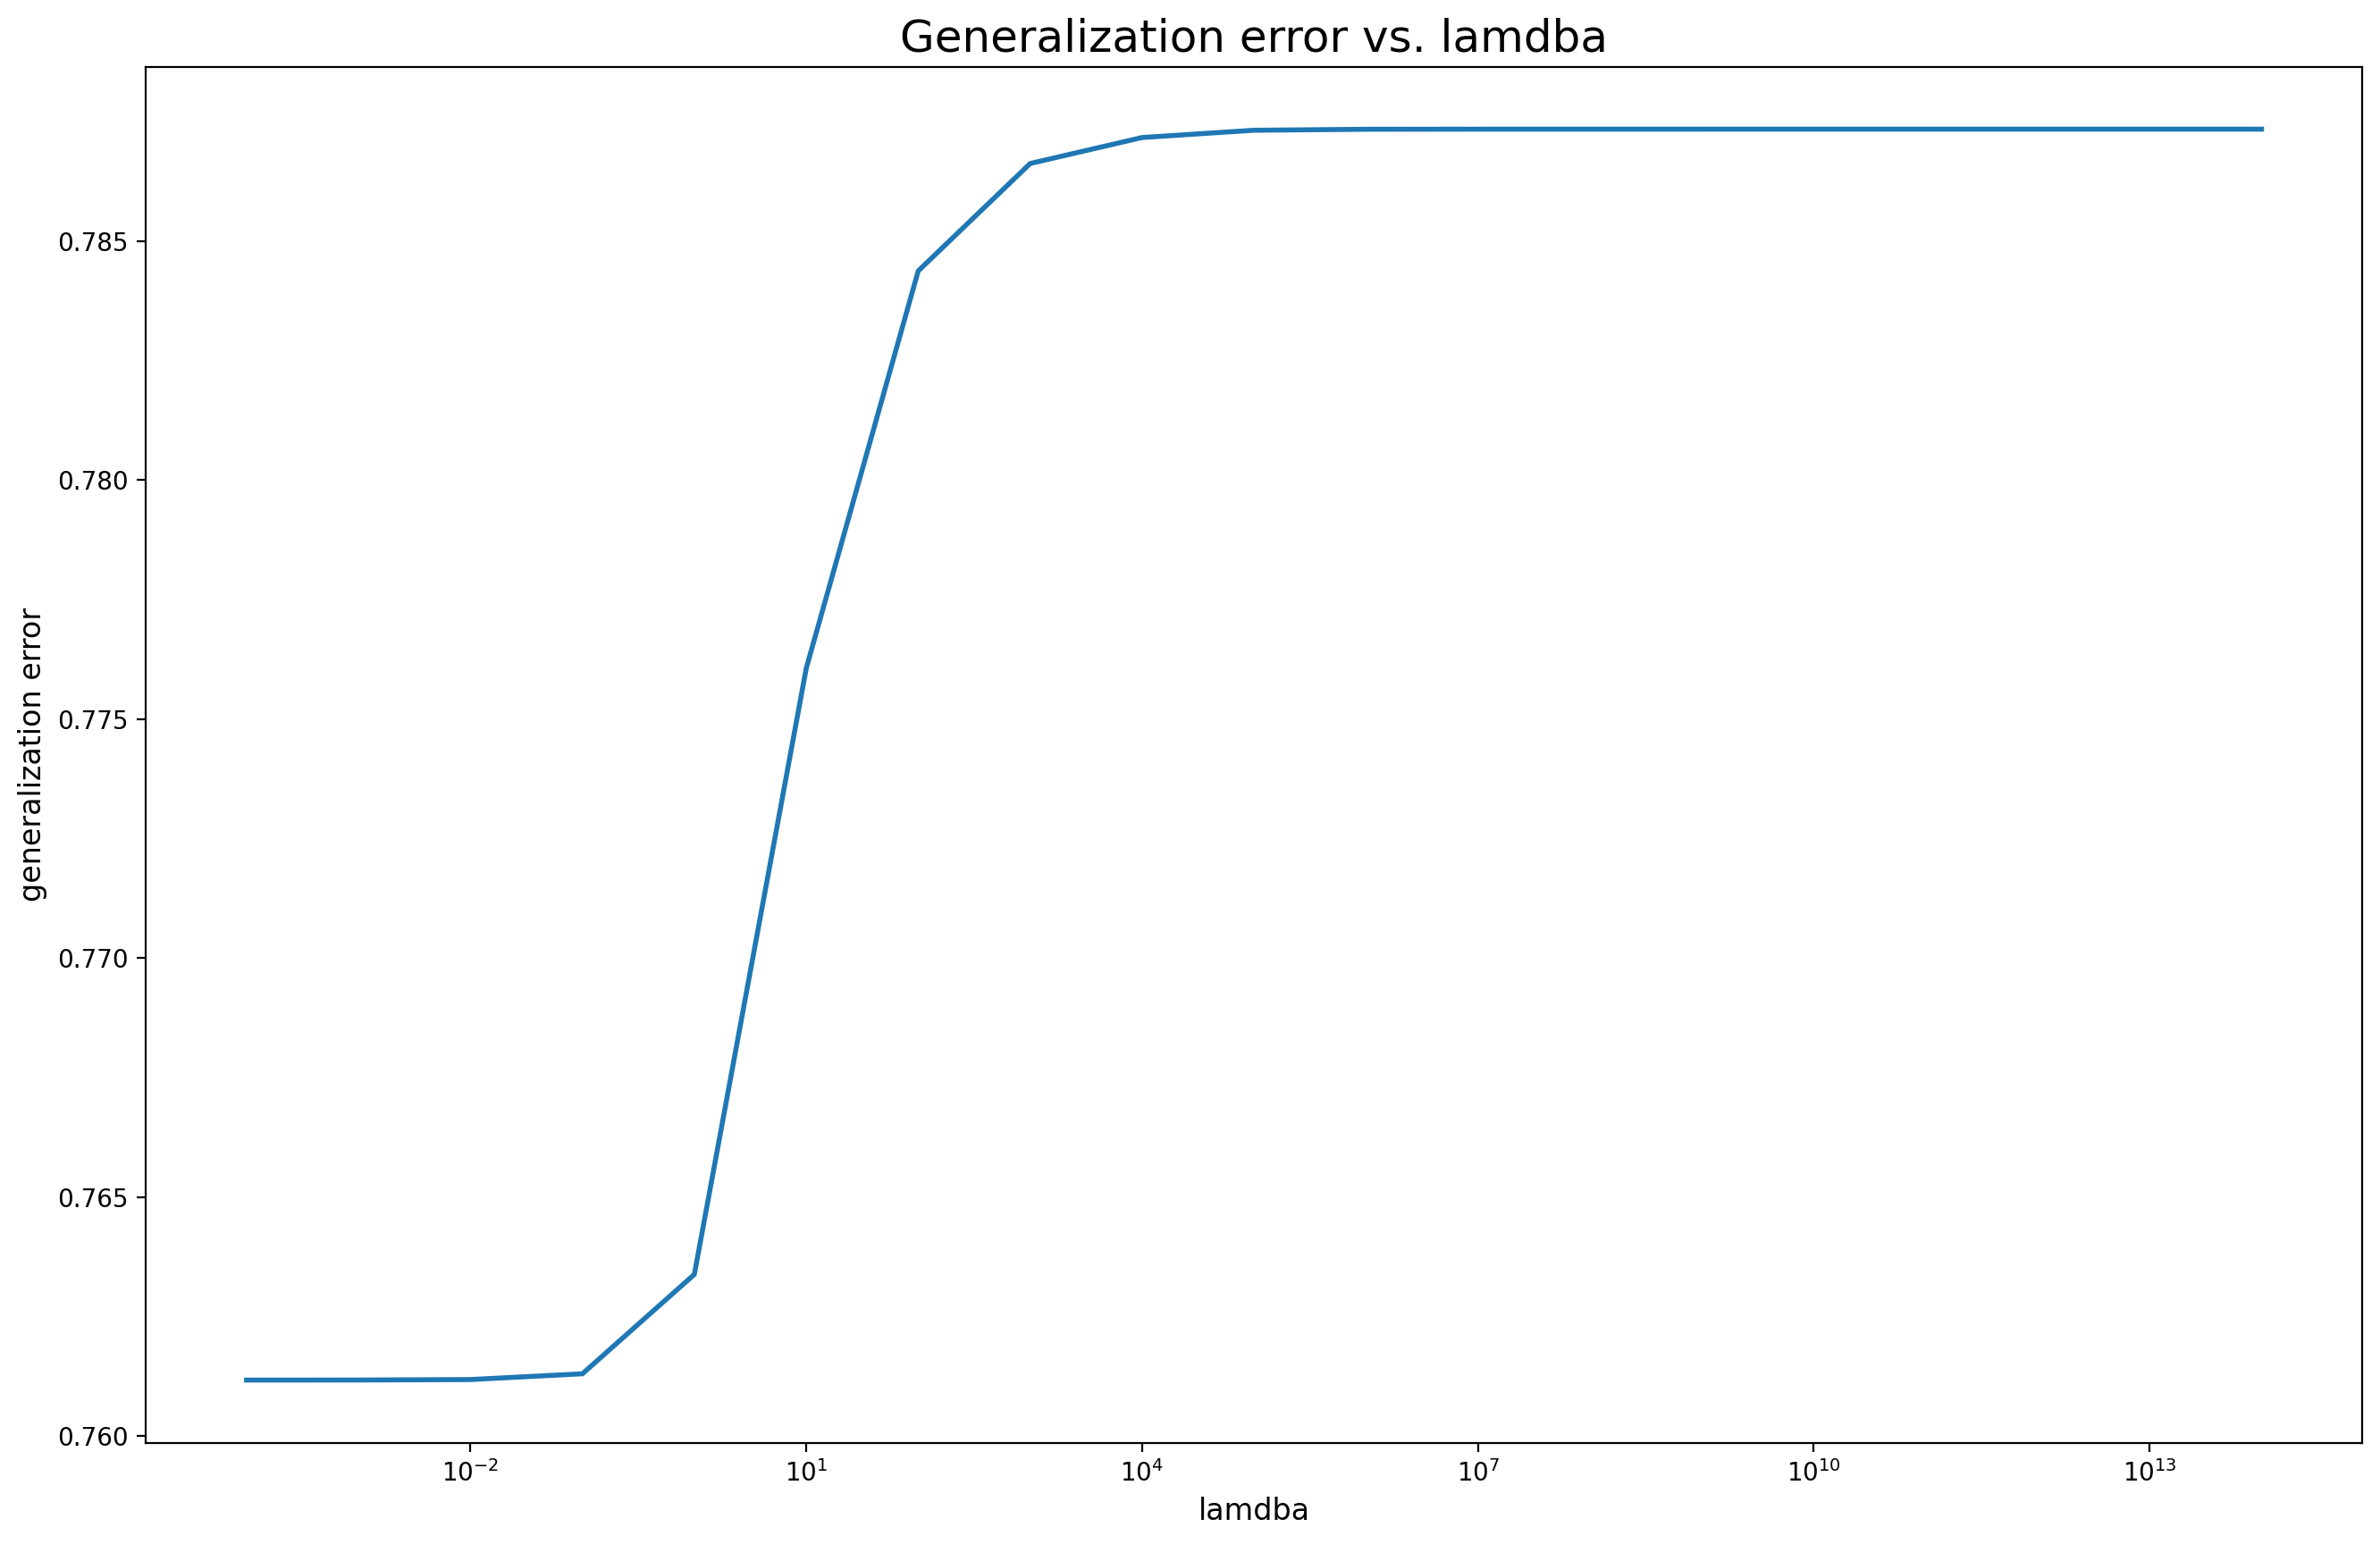

In [27]:
# plot figures
fig_1a, ax_1a = plt.subplots(figsize=(16,10))
ax_1a.semilogx(lambdas_1a, test_err_vs_lambda , linestyle= '-',linewidth=2,label='o')
ax_1a.set_xlabel('lamdba',fontsize=12)
ax_1a.set_ylabel('generalization error',fontsize=12)
ax_1a.set_title('Generalization error vs. lamdba',fontsize=18)
# save_path_1a = "../project2_figs/err_vs_lamdba.png"
# fig_1a.savefig(save_path_1a, dpi=400)
# 先降后升如何实现？？？

# Regression Part B

# Classification